# Loading and processing data:

### Loading

In [212]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [213]:
original_1 = pd.read_csv('/content/1429_1.csv',low_memory=False)
original_2 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', low_memory=False)

In [214]:
print("file 1 info:")
original_1.info()
print("file 2 info:")
original_2.info()

file 1 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  review

In [215]:
# Find duplicates based on review.text
duplicate_texts = original_1['reviews.text'].unique()
original_2 = original_2[~original_2['reviews.text'].isin(duplicate_texts)]

# Check the result
original_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14027 entries, 0 to 28249
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   14027 non-null  object 
 1   dateAdded            14027 non-null  object 
 2   dateUpdated          14027 non-null  object 
 3   name                 14027 non-null  object 
 4   asins                14027 non-null  object 
 5   brand                14027 non-null  object 
 6   categories           14027 non-null  object 
 7   primaryCategories    14027 non-null  object 
 8   imageURLs            14027 non-null  object 
 9   keys                 14027 non-null  object 
 10  manufacturer         14027 non-null  object 
 11  manufacturerNumber   14027 non-null  object 
 12  reviews.date         14027 non-null  object 
 13  reviews.dateSeen     14027 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  2040 non-null   obje

In [216]:
# reducing size of 5 star reviews by half
original_2 = original_2.drop(original_2[original_2['reviews.rating'] == 5].sample(frac=0.5, random_state=1).index)
original_2['reviews.rating'].value_counts()

reviews.rating
5    5161
4    1875
1     781
3     623
2     425
Name: count, dtype: int64

In [217]:
original_1[['id', 'name', 'categories', 'reviews.date', 'reviews.rating', 'reviews.text', 'reviews.title']].copy()

,id,name,categories,reviews.date,reviews.rating,reviews.text,reviews.title
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,5.0,This product so far has not disappointed. My c...,Kindle
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,5.0,great for beginner or experienced person. Boug...,very fast
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-12T00:00:00.000Z,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids
...,...,...,...,...,...,...,...
34655,AVpfiBlyLJeJML43-4Tp,NaN,"Computers/Tablets & Networking,Tablet & eBook ...",2012-09-18T00:00:00Z,3.0,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...
34656,AVpfiBlyLJeJML43-4Tp,NaN,"Computers/Tablets & Networking,Tablet & eBook ...",2012-11-21T00:00:00Z,1.0,Amazon should include this charger with the Ki...,Should be included
34657,AVpfiBlyLJeJML43-4Tp,NaN,"Computers/Tablets & Networking,Tablet & eBook ...",2012-10-19T00:00:00Z,1.0,Love my Kindle Fire but I am really disappoint...,Disappointing Charger
34658,AVpfiBlyLJeJML43-4Tp,NaN,"Computers/Tablets & Networking,Tablet & eBook ...",2012-10-31T00:00:00Z,1.0,I was surprised to find it did not come with a...,Not worth the money


## Processing

### File 1 Category Mapping

In [218]:
file_1 = original_1[['id', 'name', 'categories', 'reviews.date', 'reviews.rating', 'reviews.text', 'reviews.title']].copy()
file_1 = original_1.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.date'])   # dropping rows with no review text or rating
file_1['reviews.title'] = file_1['reviews.title'].fillna(" ")
file_1['name'] = file_1['name'].fillna("NA")    # replace missing product names with "NA" > used in mapping below

<ipython-input-218-c5676d665c6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_1['reviews.title'] = file_1['reviews.title'].fillna(" ")
<ipython-input-218-c5676d665c6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_1['name'] = file_1['name'].fillna("NA")    # replace missing product names with "NA" > used in mapping below


In [219]:
## Defining the mapping dicts

name_categories = {
    'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta': 'Tablets',
    'Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers,,': 'E-readers',
    'Amazon Kindle Lighted Leather Cover,,,\r\nAmazon Kindle Lighted Leather Cover,,,': 'Accessories',
    'Amazon Kindle Lighted Leather Cover,,,\r\nKindle Keyboard,,,': 'Accessories',
    'Kindle Keyboard,,,\r\nKindle Keyboard,,,': 'Accessories',
    'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta': 'Tablets',
    'Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,': 'Tablets',
    'Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,': 'Accessories',
    'All-New Kindle E-reader - Black, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers,,': 'E-readers',
    'Amazon Kindle Fire Hd (3rd Generation) 8gb,,,\r\nAmazon Kindle Fire Hd (3rd Generation) 8gb,,,': 'E-readers',
    'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta': 'Tablets',
    'Kindle Oasis E-reader with Leather Charging Cover - Black, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers,,': 'E-readers',
    'Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,,,\r\nAmazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,,,': 'E-readers',
    'Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,,,\r\nFire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",': 'E-readers',
    'Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers,': 'Tablets',
    'Amazon Standing Protective Case for Fire HD 6 (4th Generation) - Black,,,\r\nAmazon Standing Protective Case for Fire HD 6 (4th Generation) - Black,,,': 'Accessories',
    'Certified Refurbished Amazon Fire TV (Previous Generation - 1st),,,\r\nCertified Refurbished Amazon Fire TV (Previous Generation - 1st),,,': 'Streaming Devices & Smart Speakers',
    'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,,,': 'E-readers',
    'Amazon Kindle Touch Leather Case (4th Generation - 2011 Release), Olive Green,,,\r\nAmazon Kindle Touch Leather Case (4th Generation - 2011 Release), Olive Green,,,': 'Accessories',
    'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case': 'Tablets',
    'Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,': 'E-readers',
    'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,': 'E-readers',
    'Certified Refurbished Amazon Fire TV Stick (Previous Generation - 1st),,,\r\nCertified Refurbished Amazon Fire TV Stick (Previous Generation - 1st),,,': 'Streaming Devices & Smart Speakers',
    'Certified Refurbished Amazon Fire TV Stick (Previous Generation - 1st),,,\r\nKindle Paperwhite,,,': 'Streaming Devices & Smart Speakers',
    'Kindle Paperwhite,,,\r\nKindle Paperwhite,,,': 'E-readers',
    'Amazon Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case - Blue': 'Tablets',
    'Kindle Paperwhite E-reader - White, 6 High-Resolution Display (300 ppi) with Built-in Light, Wi-Fi - Includes Special Offers,,': 'E-readers',
    'Amazon Echo and Fire TV Power Adapter,,,\r\nAmazon Echo and Fire TV Power Adapter,,,': 'Accessories',
    'Amazon Fire Hd 8 8in Tablet 16gb Black B018szt3bk 6th Gen (2016) Android,,,\r\nAmazon Fire Hd 8 8in Tablet 16gb Black B018szt3bk 6th Gen (2016) Android,,,': 'Tablets',
    'Certified Refurbished Amazon Fire TV with Alexa Voice Remote,,,\r\nCertified Refurbished Amazon Fire TV with Alexa Voice Remote,,,': 'Streaming Devices & Smart Speakers',
    'Amazon - Fire 16GB (5th Gen, 2015 Release) - Black,,,\r\nAmazon - Fire 16GB (5th Gen, 2015 Release) - Black,,,': 'Tablets',
    'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Black': 'Tablets',
    'Echo (White),,,\r\nEcho (White),,,': 'Streaming Devices & Smart Speakers',
    'Echo (White),,,\r\nFire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Tangerine"': 'Streaming Devices & Smart Speakers',
    'Echo (Black),,,\r\nEcho (Black),,,': 'Streaming Devices & Smart Speakers',
    'Echo (Black),,,\r\nAmazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,': 'Accessories',
    'Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,': 'Accessories',
    'Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,\r\nAmazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,': 'Accessories',
    'Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,\r\nAmazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,': 'Accessories',
    'Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,\r\nAmazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,': 'Tablets',
    'Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,\r\nAmazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,': 'Streaming Devices & Smart Speakers',
    'Coconut Water Red Tea 16.5 Oz (pack of 12),,,\r\nAmazon Fire Tv,,,': 'Streaming Devices & Smart Speakers',
    'Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,': 'Streaming Devices & Smart Speakers',
    'Amazon Fire Tv,,,\r\nKindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs)",,': 'Accessories',
    'Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs),,': 'Accessories',
    'Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,\r\nAmazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,': 'Accessories',
    'New Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable,,,\r\nNew Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable,,,': 'Accessories',
    'New Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable,,,\r\n': 'Accessories',
    'NA': 'Uncategorized'   # for products with no names
}



na_categories = {
    'Stereos,Remote Controls,Amazon Echo,Audio Docks & Mini Speakers,Amazon Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,Kindle Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Amazon Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Amazon Devices,Audio,Holiday Shop': 'Streaming Devices & Smart Speakers',
    'Fire Tablets,Tablets,Computers & Tablets,All Tablets,Frys': 'Tablets',
    'TVs Entertainment,Wireless Speakers,Virtual Assistant Speakers,Featured Brands,Electronics,Amazon Devices,Home,Home Improvement,Home Safety & Security,Home Security,Alarms & Sensors,Smart Home & Home Automation Devices,Smart Hubs & Wireless Routers,Smart Hubs,Consumer Electronics,Voice-Enabled Smart Assistants,Smart Home & Connected Living,Home, Garage & Office,Smart Home,Voice Assistants,Surveillance,Home Automation,Speakers,Electronics Features,Holiday Shop,TV, Video & Home Audio,Internet & Media Streamers,Amazon Echo,Hubs & Controllers': 'Streaming Devices & Smart Speakers',
    'Chargers & Adapters,Computers & Accessories,Tablet & E-Reader Accessories,Amazon Devices & Accessories,Fire Tablet Accessories,Electronics,Power Adapters & Cables,Cell Phones,Amazon Device Accessories,Cell Phone Accessories,Cell Phone Batteries & Power,Tablet Accessories,Featured Brands,Kindle Fire (2nd Generation) Accessories,Kindle Store,Home Improvement,Fire (5th Generation) Accessories,Electrical,Amazon Devices,Home,Tablets & E-Readers,Cables & Chargers': 'Accessories',
    'Cases,Kindle Store,Amazon Device Accessories,Accessories,Tablet Accessories': 'Accessories',
    'Electronics,eBook Readers & Accessories,Power Adapters,Computers/Tablets & Networking,Tablet & eBook Reader Accs,Chargers & Sync Cables,Power Adapters & Cables,Kindle Store,Amazon Device Accessories,Kindle Fire (2nd Generation) Accessories,Fire Tablet Accessories': 'Accessories',
    'Electronics,Tablets & E-Readers,Tablets,Back To College,College Electronics,College Ipads & Tablets,Featured Brands,Amazon Devices,Electronics Deals,Computers & Tablets,All Tablets,Electronics Features,eBook Readers': 'Tablets',
    'Featured Brands,Electronics,Amazon Devices,Home,Home Improvement,Home Safety & Security,Home Security,Alarms & Sensors,Smart Home & Home Automation Devices,Mobile,Mobile Speakers,Mobile Bluetooth Speakers,Smart Hubs & Wireless Routers,Smart Hubs,Home, Garage & Office,Smart Home,Voice Assistants,Smart Home & Connected Living,Amazon Tap,Portable Audio,MP3 Accessories,Speakers,Amazon Echo,Electronics Features,TVs & Electronics,Portable Audio & Electronics,MP3 Player Accessories,Home Theater & Audio,Kindle Store,Frys,Electronic Components,Home Automation,Electronics, Tech Toys, Movies, Music,Audio,Bluetooth Speakers': 'Streaming Devices & Smart Speakers',
    'Rice Dishes,Ready Meals,Beauty,Moisturizers,Lotions': 'Food & Beverages',
    'Back To College,College Electronics,College Tvs & Home Theater,Electronics,Tvs & Home Theater,Streaming Devices,Featured Brands,Amazon Devices,Holiday Shop,Ways To Shop,TV & Home Theater,Streaming Media Players,All Streaming Media Players,TVs Entertainment,Video Games,Kindle Store,Electronics Features,Kids & Family,Fire TV': 'Streaming Devices & Smart Speakers',
    'Electronics,Amazon Device Accessories,Kindle Store,Covers,Kindle E-Reader Accessories,Kindle DX (2nd Generation, Global Wireless) Accessories': 'Accessories',
    'Power Adapters & Cables,Electronics,USB Cables': 'Accessories',
    'Computers/Tablets & Networking,Tablet & eBook Reader Accs,Chargers & Sync Cables,Power Adapters & Cables,Kindle Store,Amazon Device Accessories,Fire Tablet Accessories,Kindle Fire (2nd Generation) Accessories': 'Accessories',
    'Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories': 'Accessories'
}


In [220]:
## Mapping
file_1['primaryCategories'] = file_1['name'].map(name_categories).fillna('Uncategorized')   # 1st mapping: setting primary category based on product name else; Uncategorized
uncategorized_mask = file_1['primaryCategories'] == 'Uncategorized'   # defining mask for second mapping
file_1.loc[uncategorized_mask, 'primaryCategories'] = file_1.loc[uncategorized_mask, 'categories'].map(na_categories) # 2nd mapping: setting primary category for the Uncategorized based on categories

<ipython-input-220-4acd269842ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_1['primaryCategories'] = file_1['name'].map(name_categories).fillna('Uncategorized')   # 1st mapping: setting primary category based on product name else; Uncategorized


In [221]:
file_1 = file_1[file_1['primaryCategories'] != 'Food & Beverages'] # dropping this single review on a drink
file_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34597 entries, 0 to 34659
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34597 non-null  object 
 1   name                  34597 non-null  object 
 2   asins                 34595 non-null  object 
 3   brand                 34597 non-null  object 
 4   categories            34597 non-null  object 
 5   keys                  34597 non-null  object 
 6   manufacturer          34597 non-null  object 
 7   reviews.date          34597 non-null  object 
 8   reviews.dateAdded     24037 non-null  object 
 9   reviews.dateSeen      34597 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34118 non-null  float64
 14  reviews.rating        34597 non-null  float64
 15  reviews.sourceURLs    34

In [222]:
file_1['primaryCategories'].value_counts()

primaryCategories
Tablets                               16510
Streaming Devices & Smart Speakers    12533
E-readers                              4928
Accessories                             626
Name: count, dtype: int64

### Train/Test-val

In [223]:
df = file_1[['id', 'name', 'categories', 'reviews.date', 'reviews.rating', 'reviews.text', 'reviews.title', 'primaryCategories']].copy()
df.columns

Index(['id', 'name', 'categories', 'reviews.date', 'reviews.rating',
       'reviews.text', 'reviews.title', 'primaryCategories'],
      dtype='object')

In [224]:
df.dropna(subset=['reviews.text'],inplace=True)
print(len(df))

34597


In [225]:
def clean_text(text):
    # Handle non-string types
    if not isinstance(text, str):
        return ""  # Or handle it differently based on your needs

    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Remove unnecessary whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert text to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def preprocess_text(text):
    cleaned_text = clean_text(text)
    lemmatized_text = lemmatize_text(cleaned_text)
    return lemmatized_text

# Creating sentiment labels based on rating
def get_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['reviews.rating'].apply(get_sentiment)
df['processed_text'] = df['reviews.text'].apply(preprocess_text)
df.head()

,id,name,categories,reviews.date,reviews.rating,reviews.text,reviews.title,primaryCategories,sentiment,processed_text
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,5.0,This product so far has not disappointed. My c...,Kindle,Tablets,2,product far disappointed child love use like a...
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,5.0,great for beginner or experienced person. Boug...,very fast,Tablets,2,great beginner experienced person bought gift ...
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,Tablets,2,inexpensive tablet use learn step nabi thrille...
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13T00:00:00.000Z,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Tablets,2,ive fire hd 8 two week love tablet great value...
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-12T00:00:00.000Z,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,Tablets,2,bought grand daughter come visit set user ente...


In [226]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
2    32286
1     1499
0      812
Name: count, dtype: int64


In [227]:
# Separate features and target
X = df['reviews.text']
y = df['sentiment']

# Tokenizing and padding the sequences
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

# Apply SMOTE (oversampling)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(padded_sequences, y)

# # Apply RandomUnderSampler (optional, if you want to combine both)
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# Convert sentiment labels to categorical format
sentiment_labels = to_categorical(y_resampled)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, sentiment_labels, test_size=0.2, random_state=42)

# Calculate class weights
y_train_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weights_dict = dict(enumerate(class_weights))

### Test

In [228]:
test_df = original_2[['id', 'name', 'categories', 'reviews.date', 'reviews.rating', 'reviews.text', 'reviews.title', 'primaryCategories']].copy()
test_df.head()

,id,name,categories,reviews.date,reviews.rating,reviews.text,reviews.title,primaryCategories
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",2017-03-02T00:00:00.000Z,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Health & Beauty
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",2016-08-31T00:00:00.000Z,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,Health & Beauty
2,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",2016-12-06T00:00:00.000Z,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,Health & Beauty
3,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",2016-03-28T00:00:00.000Z,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Health & Beauty
4,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",2017-04-22T00:00:00.000Z,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Health & Beauty


In [229]:
test_df.dropna(inplace=True)
print(len(test_df))

# Creating sentiment labels based on rating
def get_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

test_df['sentiment'] = test_df['reviews.rating'].apply(get_sentiment)
test_df['processed_text'] = test_df['reviews.text'].apply(preprocess_text)

8865


In [230]:
# Tokenizing and padding the sequences
test_sequences = tokenizer.texts_to_sequences(test_df['reviews.text'])
X_test = pad_sequences(test_sequences, maxlen=200, padding='post', truncating='post')
y_test = to_categorical(test_df['sentiment'])



In [231]:
sentiment_counts = test_df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
2    7036
0    1206
1     623
Name: count, dtype: int64


# Modeling

## LSTM 1

### Training

In [246]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=200),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(256, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(256)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 128)          1836160   
                                                                 
 bidirectional_21 (Bidirect  (None, 200, 512)          788480    
 ional)                                                          
                                                                 
 dropout_29 (Dropout)        (None, 200, 512)          0         
                                                                 
 bidirectional_22 (Bidirect  (None, 200, 512)          1182720   
 ional)                                                          
                                                                 
 dropout_30 (Dropout)        (None, 200, 512)          0         
                                                                 
 bidirectional_23 (Bidirect  (None, 512)              

In [247]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')
history = model.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)


Epoch 1/23
2422/2422 [==============================] - 163s 64ms/step - loss: 0.8476 - accuracy: 0.5363 - precision: 0.6533 - recall: 0.3483 - val_loss: 0.7242 - val_accuracy: 0.6039 - val_precision: 0.6995 - val_recall: 0.4440
Epoch 2/23
2422/2422 [==============================] - 127s 52ms/step - loss: 0.6745 - accuracy: 0.6220 - precision: 0.6673 - recall: 0.5227 - val_loss: 0.6645 - val_accuracy: 0.6410 - val_precision: 0.6551 - val_recall: 0.6143
Epoch 3/23
2422/2422 [==============================] - 125s 52ms/step - loss: 0.5828 - accuracy: 0.6597 - precision: 0.6758 - recall: 0.6224 - val_loss: 0.5790 - val_accuracy: 0.6784 - val_precision: 0.6918 - val_recall: 0.6505
Epoch 4/23
2422/2422 [==============================] - 124s 51ms/step - loss: 0.5388 - accuracy: 0.6917 - precision: 0.6997 - recall: 0.6736 - val_loss: 0.5616 - val_accuracy: 0.6990 - val_precision: 0.7092 - val_recall: 0.6850
Epoch 5/23
2422/2422 [==============================] - 124s 51ms/step - loss: 0.510

In [248]:
evaluation = model.evaluate(X_val, y_val)

# Print the results
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')
print(f'Validation Precision: {evaluation[2]}')
print(f'Validation Recall: {evaluation[3]}')


606/606 [==============================] - 12s 20ms/step - loss: 0.5508 - accuracy: 0.7214 - precision: 0.7279 - recall: 0.7128
Validation Loss: 0.5507879853248596
Validation Accuracy: 0.7213504314422607
Validation Precision: 0.7279388308525085
Validation Recall: 0.7128329277038574


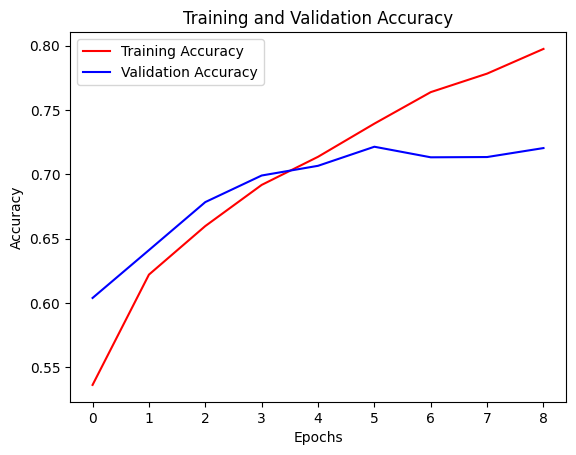

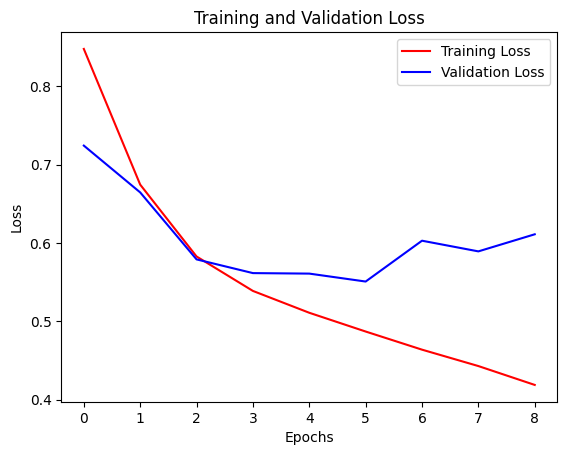

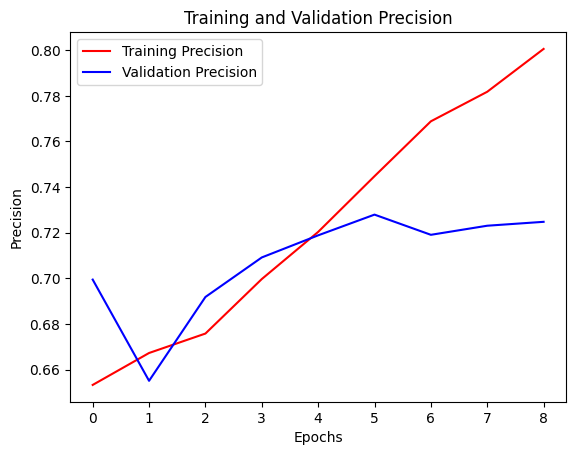

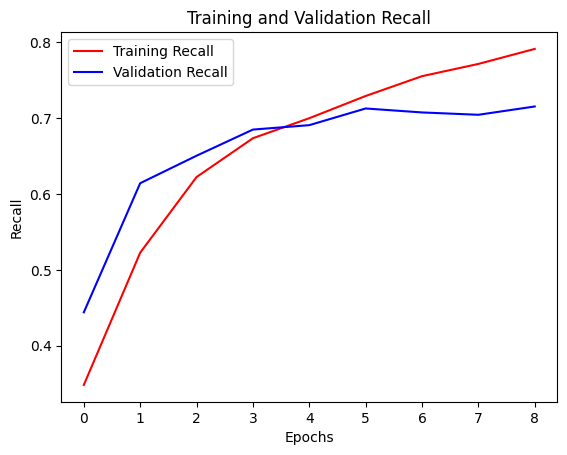

In [249]:
# Retrieve history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation precision
plt.figure()
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure()
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Prediction

In [250]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

278/278 [==============================] - 7s 18ms/step
Accuracy: 0.6770445572476029
Precision: 0.7695964086643058
Recall: 0.6770445572476029
F1-score: 0.7136845481446679


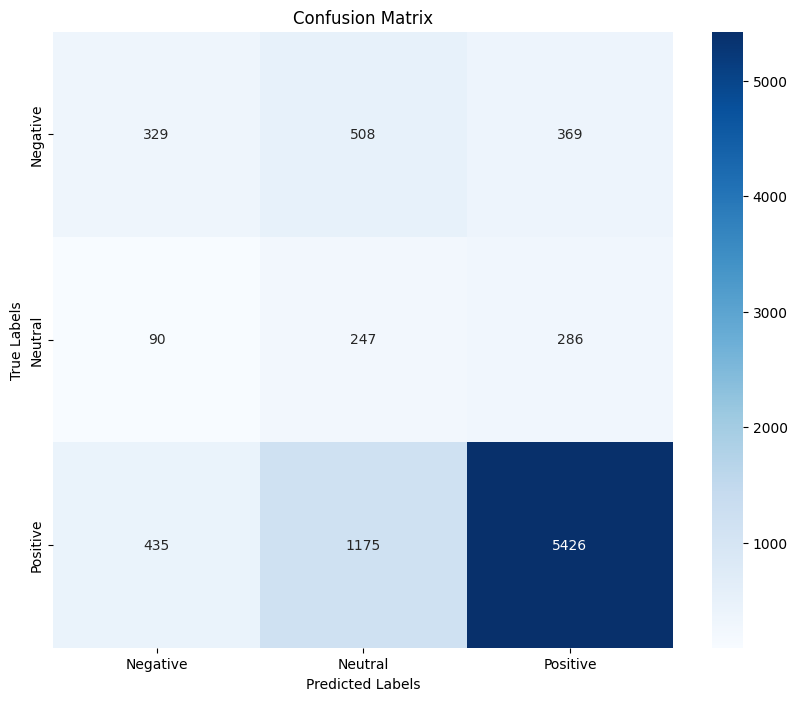

In [251]:
# confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [252]:
# Identify wrong predictions
wrong_predictions = np.where(y_pred != y_true)[0]

# Extract the corresponding review texts, ratings, and sentiments
wrong_samples = test_df.iloc[wrong_predictions].copy()

# Add predicted sentiment to the wrong samples using .loc
wrong_samples.loc[:, 'predicted_sentiment'] = y_pred[wrong_predictions]

# Map numeric sentiments to string labels (optional, for better readability)
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
wrong_samples.loc[:, 'sentiment'] = wrong_samples['sentiment'].map(sentiment_mapping)
wrong_samples.loc[:, 'predicted_sentiment'] = wrong_samples['predicted_sentiment'].map(sentiment_mapping)

# Display some of the wrong predictions
wrong_samples[['reviews.rating', 'reviews.text', 'sentiment', 'predicted_sentiment']].head(10)

,reviews.rating,reviews.text,sentiment,predicted_sentiment
0,3,I order 3 of them and one of the item is bad q...,Neutral,Positive
2,5,Well they are not Duracell but for the price i...,Positive,Neutral
3,5,Seem to work as well as name brand batteries a...,Positive,Neutral
8,3,These do not hold the amount of high power jui...,Neutral,Negative
11,3,When I first started getting the Amazon basic ...,Neutral,Positive
16,1,I don't know if I would buy thus brand again s...,Negative,Neutral
19,3,Bought these batteries for my Christmas gifts ...,Neutral,Negative
22,5,They last as long as Duracell batteries in my ...,Positive,Neutral
23,4,they seemed to not last as long as other name ...,Positive,Neutral
24,1,These do not last long at all very cheap batte...,Negative,Positive


## *LSTM 2*

### Training

In [232]:
model_2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=200),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model_2.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 128)          1836160   
                                                                 
 bidirectional_17 (Bidirect  (None, 200, 256)          263168    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 200, 256)          0         
                                                                 
 bidirectional_18 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 64)               

In [233]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')
history = model_2.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)

Epoch 1/23
2422/2422 [==============================] - 122s 48ms/step - loss: 0.7287 - accuracy: 0.6022 - precision: 0.6592 - recall: 0.4917 - val_loss: 0.6058 - val_accuracy: 0.6516 - val_precision: 0.6788 - val_recall: 0.6033
Epoch 2/23
2422/2422 [==============================] - 88s 36ms/step - loss: 0.5785 - accuracy: 0.6807 - precision: 0.6974 - recall: 0.6450 - val_loss: 0.5613 - val_accuracy: 0.7053 - val_precision: 0.7195 - val_recall: 0.6774
Epoch 3/23
2422/2422 [==============================] - 87s 36ms/step - loss: 0.5230 - accuracy: 0.7281 - precision: 0.7365 - recall: 0.7125 - val_loss: 0.5594 - val_accuracy: 0.7157 - val_precision: 0.7234 - val_recall: 0.7061
Epoch 4/23
2422/2422 [==============================] - 87s 36ms/step - loss: 0.4858 - accuracy: 0.7516 - precision: 0.7576 - recall: 0.7419 - val_loss: 0.5502 - val_accuracy: 0.7184 - val_precision: 0.7263 - val_recall: 0.7066
Epoch 5/23
2422/2422 [==============================] - 86s 36ms/step - loss: 0.4576 - 

In [234]:
evaluation = model_2.evaluate(X_val, y_val)

# Print the results
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')
print(f'Validation Precision: {evaluation[2]}')
print(f'Validation Recall: {evaluation[3]}')


606/606 [==============================] - 8s 14ms/step - loss: 0.5502 - accuracy: 0.7184 - precision: 0.7263 - recall: 0.7066
Validation Loss: 0.5501931309700012
Validation Accuracy: 0.7184079885482788
Validation Precision: 0.7262839674949646
Validation Recall: 0.7066384553909302


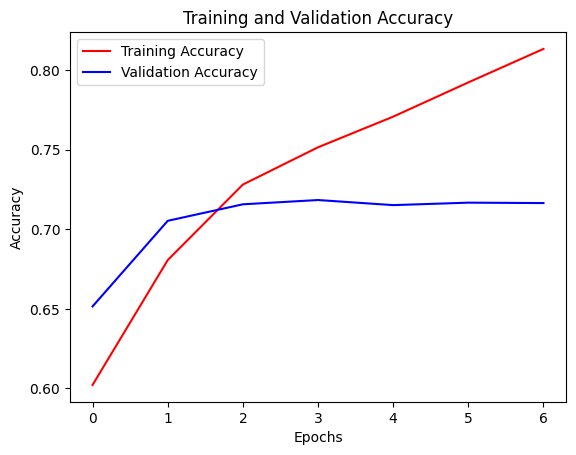

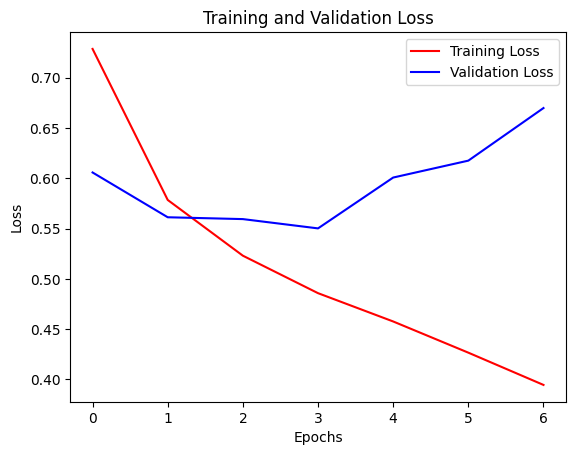

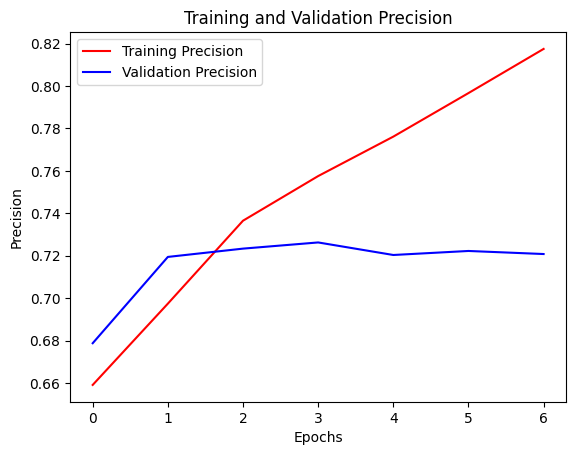

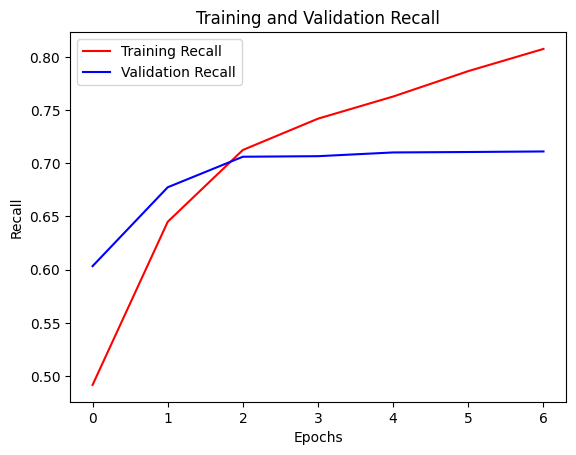

In [235]:
# Retrieve history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation precision
plt.figure()
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure()
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Prediction

In [236]:
# Make predictions on the test data
y_pred_prob = model_2.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

278/278 [==============================] - 5s 12ms/step
Accuracy: 0.693288212069938
Precision: 0.7584461059297226
Recall: 0.693288212069938
F1-score: 0.7193555879719224


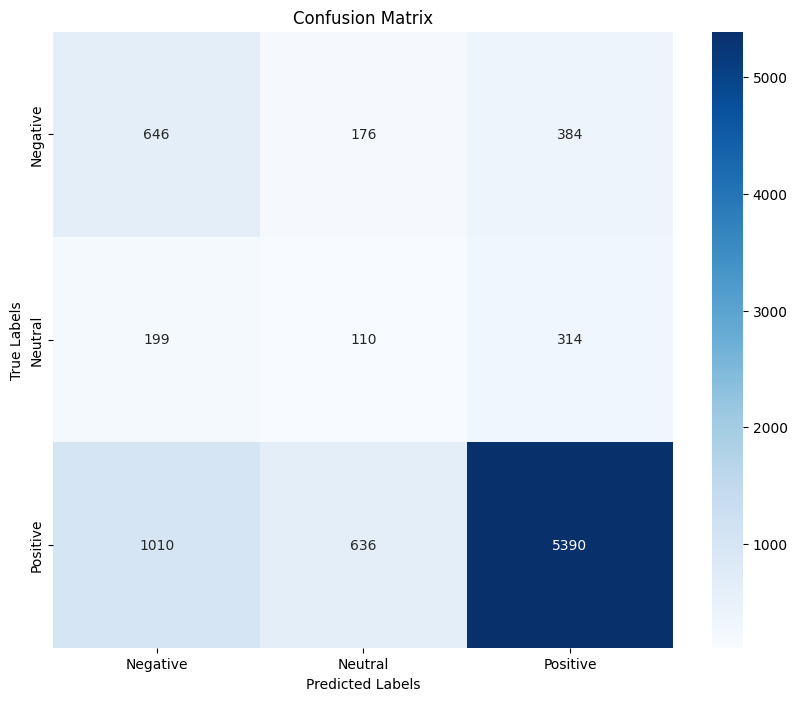

In [237]:
# confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [238]:
# Identify wrong predictions
wrong_predictions = np.where(y_pred != y_true)[0]

# Extract the corresponding review texts, ratings, and sentiments
wrong_samples = test_df.iloc[wrong_predictions].copy()

# Add predicted sentiment to the wrong samples using .loc
wrong_samples.loc[:, 'predicted_sentiment'] = y_pred[wrong_predictions]

# Map numeric sentiments to string labels (optional, for better readability)
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
wrong_samples.loc[:, 'sentiment'] = wrong_samples['sentiment'].map(sentiment_mapping)
wrong_samples.loc[:, 'predicted_sentiment'] = wrong_samples['predicted_sentiment'].map(sentiment_mapping)

# Display some of the wrong predictions
wrong_samples[['reviews.rating', 'reviews.text', 'sentiment', 'predicted_sentiment']].head(10)

,reviews.rating,reviews.text,sentiment,predicted_sentiment
0,3,I order 3 of them and one of the item is bad q...,Neutral,Positive
2,5,Well they are not Duracell but for the price i...,Positive,Negative
11,3,When I first started getting the Amazon basic ...,Neutral,Positive
17,2,In my opinion these did not last anywhere near...,Negative,Neutral
19,3,Bought these batteries for my Christmas gifts ...,Neutral,Negative
22,5,They last as long as Duracell batteries in my ...,Positive,Neutral
24,1,These do not last long at all very cheap batte...,Negative,Positive
26,4,These Amazon batteries did the job although I ...,Positive,Negative
28,5,HAVE NOT HAD CHANCE TO USE ALL OF THEM BUT HOP...,Positive,Neutral
29,3,these were under a light we thought they were ...,Neutral,Positive


In [265]:
# model_save_path = '/content/drive/My Drive/final_LSTM_model2'
# model_2.save(model_save_path)

# # # Download the model file
# # from google.colab import files
# # files.download(model_save_path)

## LSTM 3

### Training

In [239]:
model_3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=200),
    Conv1D(256, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model_3.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 128)          1836160   
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 98, 256)           0         
 g1D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 98, 256)           0         
                                                                 
 bidirectional_19 (Bidirect  (None, 98, 256)           394240    
 ional)                                                          
                                                                 
 dropout_26 (Dropout)        (None, 98, 256)          

In [240]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')
history = model_3.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)


Epoch 1/23
2422/2422 [==============================] - 96s 37ms/step - loss: 0.6571 - accuracy: 0.6295 - precision: 0.6673 - recall: 0.5506 - val_loss: 0.5668 - val_accuracy: 0.6774 - val_precision: 0.6973 - val_recall: 0.6352
Epoch 2/23
2422/2422 [==============================] - 61s 25ms/step - loss: 0.5481 - accuracy: 0.6803 - precision: 0.6914 - recall: 0.6555 - val_loss: 0.5598 - val_accuracy: 0.6959 - val_precision: 0.7069 - val_recall: 0.6805
Epoch 3/23
2422/2422 [==============================] - 59s 24ms/step - loss: 0.5132 - accuracy: 0.7160 - precision: 0.7238 - recall: 0.7008 - val_loss: 0.5394 - val_accuracy: 0.7061 - val_precision: 0.7139 - val_recall: 0.6933
Epoch 4/23
2422/2422 [==============================] - 59s 24ms/step - loss: 0.4828 - accuracy: 0.7445 - precision: 0.7511 - recall: 0.7342 - val_loss: 0.5560 - val_accuracy: 0.7187 - val_precision: 0.7249 - val_recall: 0.7105
Epoch 5/23
2422/2422 [==============================] - 59s 24ms/step - loss: 0.4540 - a

In [241]:
evaluation = model_3.evaluate(X_val, y_val)

# Print the results
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')
print(f'Validation Precision: {evaluation[2]}')
print(f'Validation Recall: {evaluation[3]}')


606/606 [==============================] - 6s 9ms/step - loss: 0.5394 - accuracy: 0.7061 - precision: 0.7139 - recall: 0.6933
Validation Loss: 0.5394035577774048
Validation Accuracy: 0.7061222195625305
Validation Precision: 0.7139212489128113
Validation Recall: 0.6933202743530273


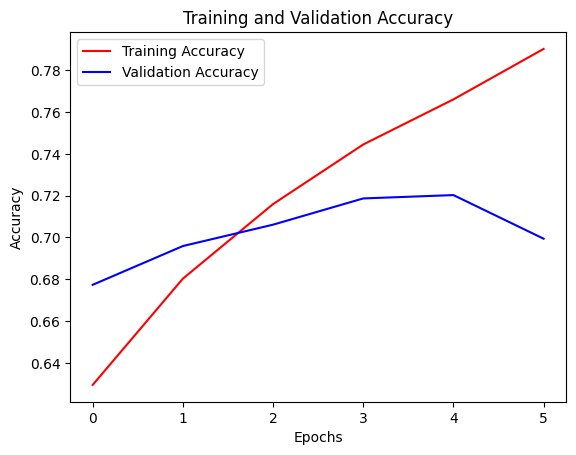

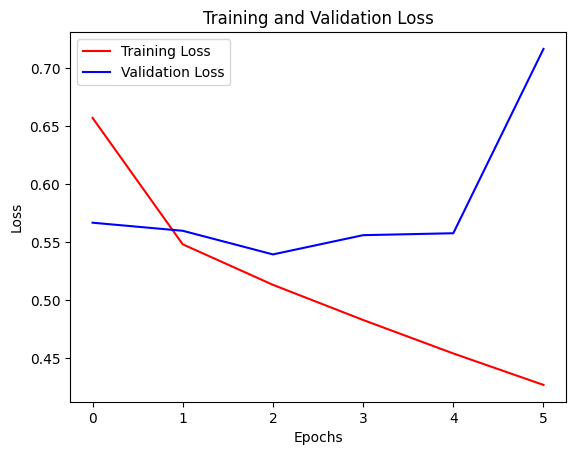

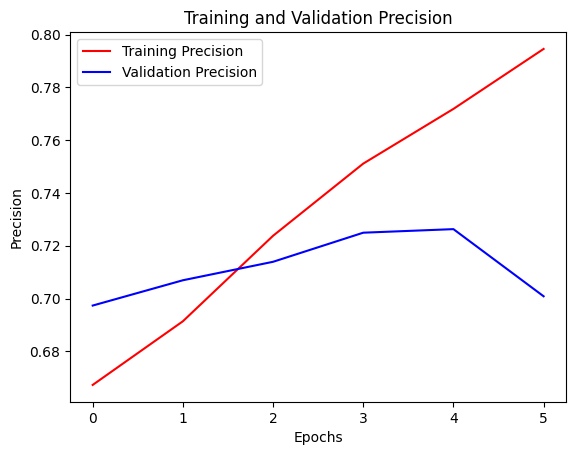

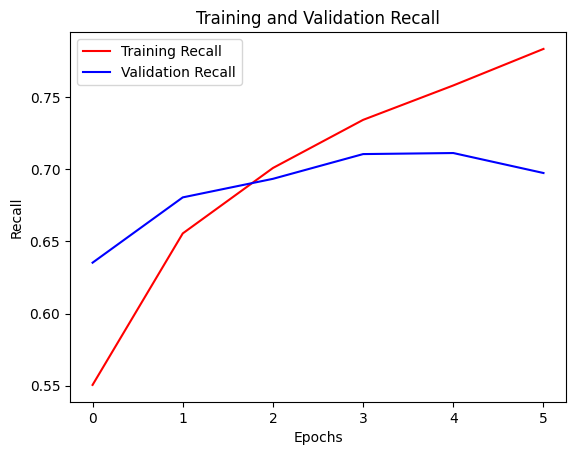

In [242]:
# Retrieve history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation precision
plt.figure()
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure()
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Prediction

In [243]:
# Make predictions on the test data
y_pred_prob = model_3.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

278/278 [==============================] - 4s 8ms/step
Accuracy: 0.6939650310208686
Precision: 0.7565007779517136
Recall: 0.6939650310208686
F1-score: 0.7187386463489153


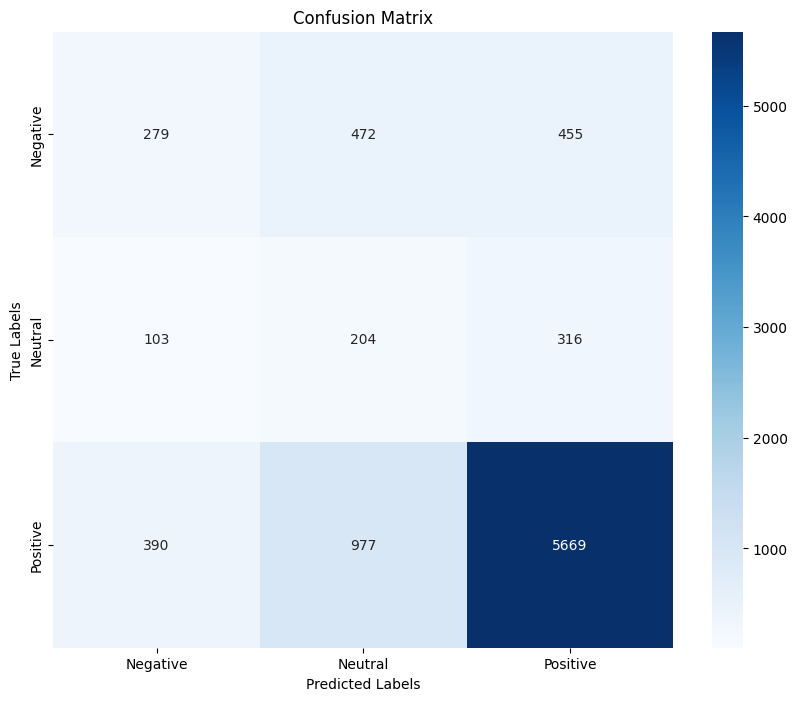

In [244]:
# confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [245]:
# Identify wrong predictions
wrong_predictions = np.where(y_pred != y_true)[0]

# Extract the corresponding review texts, ratings, and sentiments
wrong_samples = test_df.iloc[wrong_predictions].copy()

# Add predicted sentiment to the wrong samples using .loc
wrong_samples.loc[:, 'predicted_sentiment'] = y_pred[wrong_predictions]

# Map numeric sentiments to string labels (optional, for better readability)
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
wrong_samples.loc[:, 'sentiment'] = wrong_samples['sentiment'].map(sentiment_mapping)
wrong_samples.loc[:, 'predicted_sentiment'] = wrong_samples['predicted_sentiment'].map(sentiment_mapping)

# Display some of the wrong predictions
wrong_samples[['reviews.rating', 'reviews.text', 'sentiment', 'predicted_sentiment']].head(10)

,reviews.rating,reviews.text,sentiment,predicted_sentiment
0,3,I order 3 of them and one of the item is bad q...,Neutral,Positive
2,5,Well they are not Duracell but for the price i...,Positive,Negative
8,3,These do not hold the amount of high power jui...,Neutral,Negative
11,3,When I first started getting the Amazon basic ...,Neutral,Positive
14,5,we have many things that need aa battery they ...,Positive,Neutral
16,1,I don't know if I would buy thus brand again s...,Negative,Neutral
17,2,In my opinion these did not last anywhere near...,Negative,Neutral
22,5,They last as long as Duracell batteries in my ...,Positive,Negative
26,4,These Amazon batteries did the job although I ...,Positive,Negative
29,3,these were under a light we thought they were ...,Neutral,Positive


## *LSTM 4*

### Training

In [268]:
model_4 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=200),
    Bidirectional(LSTM(512, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(512)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model_4.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 128)          1836160   
                                                                 
 bidirectional_30 (Bidirect  (None, 200, 1024)         2625536   
 ional)                                                          
                                                                 
 dropout_41 (Dropout)        (None, 200, 1024)         0         
                                                                 
 bidirectional_31 (Bidirect  (None, 1024)              6295552   
 ional)                                                          
                                                                 
 dropout_42 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 128)             

In [269]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')
history = model_4.fit(X_train, y_train, epochs=23, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)

Epoch 1/23
1211/1211 [==============================] - 94s 73ms/step - loss: 0.7758 - accuracy: 0.5844 - precision: 0.6576 - recall: 0.4387 - val_loss: 0.6946 - val_accuracy: 0.6251 - val_precision: 0.6785 - val_recall: 0.5200
Epoch 2/23
1211/1211 [==============================] - 62s 51ms/step - loss: 0.9101 - accuracy: 0.5267 - precision: 0.6387 - recall: 0.2892 - val_loss: 0.8209 - val_accuracy: 0.5677 - val_precision: 0.7055 - val_recall: 0.3298
Epoch 3/23
1211/1211 [==============================] - 61s 50ms/step - loss: 0.7212 - accuracy: 0.6009 - precision: 0.6621 - recall: 0.4761 - val_loss: 0.6965 - val_accuracy: 0.5966 - val_precision: 0.6184 - val_recall: 0.5443
Epoch 4/23
1211/1211 [==============================] - 60s 50ms/step - loss: 0.6680 - accuracy: 0.6271 - precision: 0.6676 - recall: 0.5370 - val_loss: 0.6923 - val_accuracy: 0.6303 - val_precision: 0.6666 - val_recall: 0.5494
Epoch 5/23
1211/1211 [==============================] - 60s 49ms/step - loss: 0.6232 - a

In [270]:
evaluation = model_4.evaluate(X_val, y_val)

# Print the results
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')
print(f'Validation Precision: {evaluation[2]}')
print(f'Validation Recall: {evaluation[3]}')


606/606 [==============================] - 12s 19ms/step - loss: 0.5899 - accuracy: 0.7110 - precision: 0.7235 - recall: 0.6953
Validation Loss: 0.5899065136909485
Validation Accuracy: 0.7110262513160706
Validation Precision: 0.7235174179077148
Validation Recall: 0.6952818632125854


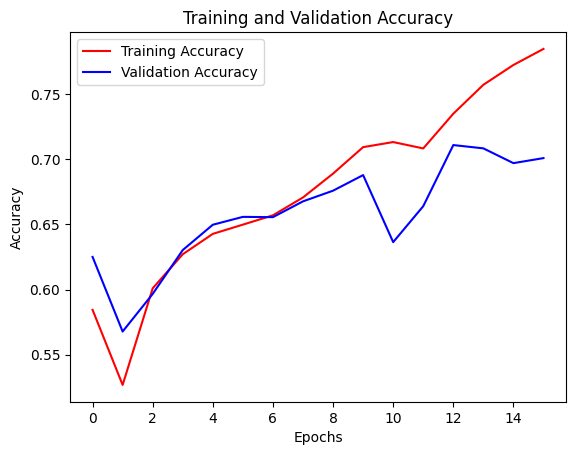

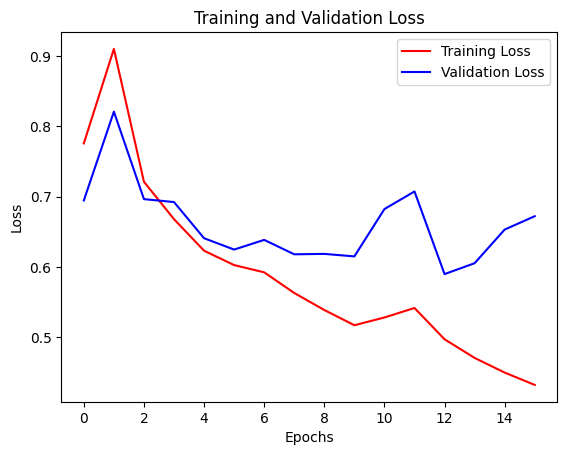

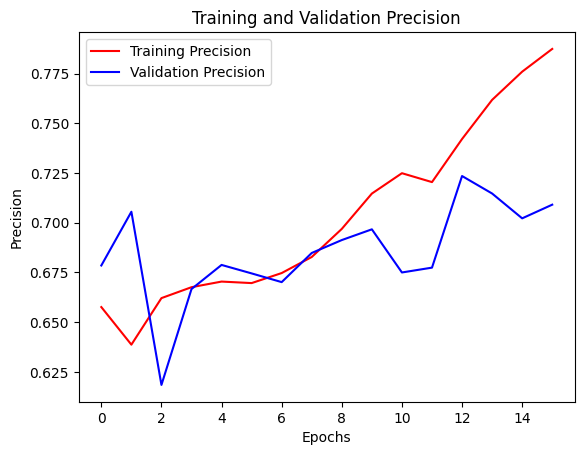

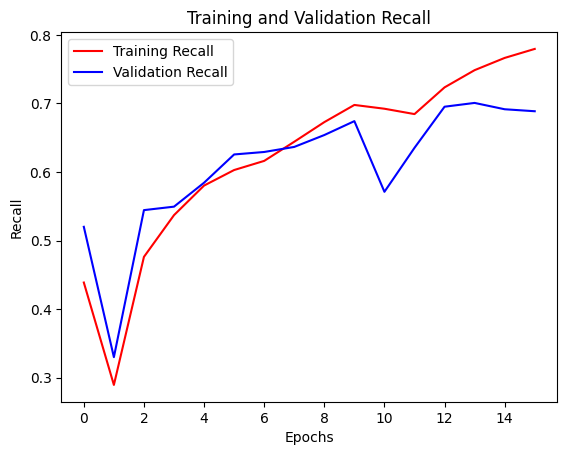

In [271]:
# Retrieve history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation precision
plt.figure()
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure()
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Prediction

In [272]:
# Make predictions on the test data
y_pred_prob = model_4.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

278/278 [==============================] - 6s 17ms/step
Accuracy: 0.7130287648054145
Precision: 0.7612363952872192
Recall: 0.7130287648054145
F1-score: 0.7342564335147488


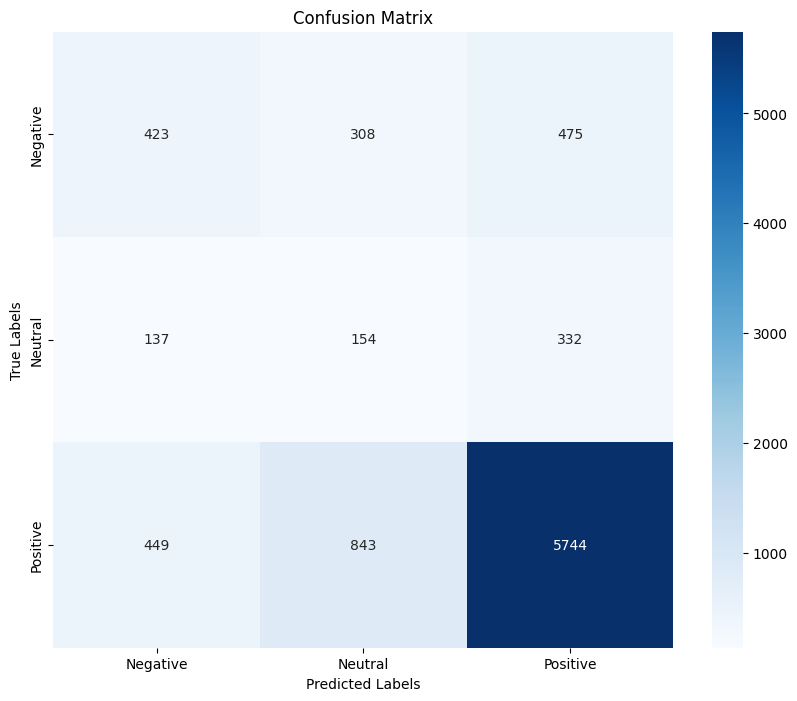

In [273]:
# confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [274]:
# Identify wrong predictions
wrong_predictions = np.where(y_pred != y_true)[0]

# Extract the corresponding review texts, ratings, and sentiments
wrong_samples = test_df.iloc[wrong_predictions].copy()

# Add predicted sentiment to the wrong samples using .loc
wrong_samples.loc[:, 'predicted_sentiment'] = y_pred[wrong_predictions]

# Map numeric sentiments to string labels (optional, for better readability)
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
wrong_samples.loc[:, 'sentiment'] = wrong_samples['sentiment'].map(sentiment_mapping)
wrong_samples.loc[:, 'predicted_sentiment'] = wrong_samples['predicted_sentiment'].map(sentiment_mapping)

# Display some of the wrong predictions
wrong_samples[['reviews.rating', 'reviews.text', 'sentiment', 'predicted_sentiment']].head(10)

,reviews.rating,reviews.text,sentiment,predicted_sentiment
0,3,I order 3 of them and one of the item is bad q...,Neutral,Positive
2,5,Well they are not Duracell but for the price i...,Positive,Neutral
8,3,These do not hold the amount of high power jui...,Neutral,Negative
11,3,When I first started getting the Amazon basic ...,Neutral,Positive
14,5,we have many things that need aa battery they ...,Positive,Neutral
22,5,They last as long as Duracell batteries in my ...,Positive,Negative
24,1,These do not last long at all very cheap batte...,Negative,Neutral
26,4,These Amazon batteries did the job although I ...,Positive,Neutral
29,3,these were under a light we thought they were ...,Neutral,Positive
38,5,These last as well as Energizer- half the price.,Positive,Neutral


In [275]:
# model_save_path = '/content/drive/My Drive/final_LSTM_model_final'
# model_4.save(model_save_path)